### Fraud Detection with Variational Autoencoder

In my previous naive attempt at applying autoencoders to fraud detection, I trained a simple autoencoder with one hidden layer on each of the encoder side and decoder side. The autoencoder was asymmetrical and overcomplete, i.e. the hidden layer dimensions and the latent dimension were asymetrical and larger than the input size. Even so, it seemed to perform alright by piping the latent encoding through a simple linear classifer. An adversarial net was also tried out, but only as a classifier alternative to the linear benchmark. This may be something I would revisit in the future.

In this new attempt, using the same credit card data by ULB machine learning group, I explore applying Variational Autoencoders (VAE) to the same problem. Functionally, Variational Autoencoders also try to reconstruct the input, but with the additional contraint that the latent representation learns the probability distribution parameters of the input rather than an arbitrary encoding of the input, hance the "Variational". What's good about learning the distribution? One, by explicitly modeling the data and noise generation processes, VAE can learn to separate the two, making it more robust. Two, the latent space can become more interpreble if disentanglement constraints are applied. Three, you can generate new samples by sampling latent vectors and pipe them through the decoder. There are more points and I will leave the technical details to the true professionals. You can find the resources that helped me below.

### Contents
1. Raw Dataset
2. Visualize Preprocessed Transaction Features
3. Train a Variational Autoencoder
4. Visualize Latent Representations
5. VAE vs SVM
6. Evaluation on Test Set
7. Limitations

In [1]:
import numpy as np

In [2]:
!pip install --upgrade --pre tensorflow

  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.10.0.dev20220721 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tf-nightly-gpu 2.10.0.dev20220721 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.


  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [3]:
!pip install --upgrade --pre tensorflow-gpu

  Using cached tensorflow_gpu-2.9.1-cp39-cp39-win_amd64.whl (444.0 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.10.0.dev20220721 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tf-nightly-gpu 2.10.0.dev20220721 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.


In [4]:
!pip install --upgrade tf-nightly  --user
!pip install --upgrade tf-nightly-gpu

     -------------------------------------- 362.0/362.0 MB 4.1 MB/s eta 0:00:00
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Attempting uninstall: tf-nightly
    Found existing installation: tf-nightly 2.10.0.dev20220721
    Uninstalling tf-nightly-2.10.0.dev20220721:
      Successfully uninstalled tf-nightly-2.10.0.dev20220721


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\sarah\\AppData\\Roaming\\Python\\Python39\\site-packages\\~ensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Check the permissions.



     -------------------------------------- 362.0/362.0 MB 3.8 MB/s eta 0:00:00


  Attempting uninstall: tf-nightly-gpu
    Found existing installation: tf-nightly-gpu 2.10.0.dev20220721
    Uninstalling tf-nightly-gpu-2.10.0.dev20220721:
      Successfully uninstalled tf-nightly-gpu-2.10.0.dev20220721


In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [6]:
import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

In [7]:
!pip3 install --upgrade tensorflow-probability

In [8]:
pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.1.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
alembic                       1.8.1
anaconda-client               1.9.0
anaconda-navigator            2.2.0
anaconda-project              0.10.2
anyio                         3.5.0
Note: you may need to restart the kernel to use updated packages.appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall    

bkcharts                      0.2
black                         19.10b0
bleach                        4.1.0
blis                          0.7.8
bokeh                         2.4.2
boto3                         1.21.32
botocore                      1.24.32
Bottleneck                    1.3.4
brotlipy                      0.7.0
bw2python                     0.6.1
cachetools                    4.2.2
catalogue                     2.0.7
catboost                      1.0.6
certifi                       2022.6.15
cffi                          1.15.0
chardet                       4.0.0
charset-normalizer            2.0.4
click                         8.0.4
cloudpickle                   2.0.0
clyent                        1.2.2
colorama                      0.4.4
colorcet                      2.0.6
colorlover                    0.3.0
comtypes                      1.1.10
concat                        0.1.2.dev1
conda                         4.13.0
conda-build                   3.21.8
conda-conte

In [9]:
!pip3 install tensorflow-probability


pyasn1-modules                0.2.8
pycapnp                       1.1.1
pycaret                       2.2.2
pycodestyle                   2.7.0
pycosat                       0.6.3
pycparser                     2.21
pyct                          0.4.6
pycurl                        7.44.1
pydantic                      1.9.1
PyDispatcher                  2.0.5
pydocstyle                    6.1.1
pyerfa                        2.0.0
pyflakes                      2.3.1
Pygments                      2.11.2
PyHamcrest                    2.0.2
PyJWT                         2.1.0
pyLDAvis                      3.3.1
pylint                        2.9.6
pyls-spyder                   0.4.0
PyNaCl                        1.4.0
pynndescent                   0.5.7
pyod                          1.0.3
pyodbc                        4.0.32
pyOpenSSL                     21.0.0
pyparsing                     3.0.4
pyreadline                    2.1
pyrsistent                    0.18.0
PySocks                  

In [10]:
!pip install --upgrade tf-nightly 
!pip install --upgrade tf-nightly-gpu

In [11]:
!pip install --user tensorflow --upgrade

  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.10.0.dev20220724 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
tf-nightly-gpu 2.10.0.dev20220724 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.


  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [12]:
!pip install --user tensorflow-probability --upgrade

In [13]:
!pip install --upgrade tensorflow-probability

In [14]:
import tensorflow_probability as tfp

In [15]:
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

In [16]:
from tensorflow.keras.utils import plot_model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

In [18]:
%matplotlib inline
np.random.seed(0)
tf.random.set_seed(0)
print(tf.__version__)
print(tfp.__version__)

2.10.0-dev20220724
0.17.0


In [19]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
#     plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud', s=2)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud', s=2)

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()
    

### 1. Raw Dataset

In [20]:
td = pd.read_csv('C:/Users/sarah/Desktop/github/open/train.csv')
td['Class'] = 0

In [21]:
td.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972,0
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972,0
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960,0
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901,0
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901,0


In [22]:
td.shape

(113842, 32)

In [23]:
non_fraud = td[td['Class'] == 0].sample(1000)
fraud = td[td['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31164\3837308552.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)


In [26]:
!pip install pydot

### 3. Train a Variational Autoencoder 여기서부터 해보자


In [27]:
def dense_layers(sizes):
    return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

original_dim = X.shape[1]
input_shape = X[0].shape
intermediary_dims = [20, 10, 8]
latent_dim = 2
batch_size = 128
max_epochs = 1000

# prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
#                         reinterpreted_batch_ndims=1)

prior = tfd.MultivariateNormalDiag(
        loc=tf.zeros([latent_dim]),
        scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    dense_layers(intermediary_dims),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, 
                           activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
], name='encoder')

encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
    tfpl.IndependentNormal(original_dim),
], name='decoder')

decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]),
                name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
            loss=negloglik)

vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 8)                 938       
                                                                 
 dense_11 (Dense)            (None, 5)                 45        
                                                                 
 multivariate_normal_tri_l_1  ((None, 2),              0         
  (MultivariateNormalTriL)    (None, 2))                         
                                                                 
Total params: 983
Trainable params: 983
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "decoder"
_________________________________________________________________
 Layer (type)              

In [29]:
x = td.drop(["Class"], axis=1)
y = td["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [30]:
tf_train = tf.data.Dataset.from_tensor_slices((x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))
tf_val = tf.data.Dataset.from_tensor_slices((x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

TypeError: __init__() got an unexpected keyword argument 'basey'

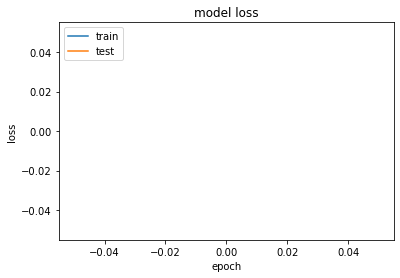

In [31]:
checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(tf_train,
               epochs=max_epochs,
               shuffle=True,
               verbose=0,
               validation_data=tf_val,
               callbacks=[checkpointer, earlystopper])

plot_loss(hist)

In [32]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

In [25]:
x_test_log_prob = reconstruction_log_prob(data_test.drop(['Class'], axis = 1).values, reconstruct_samples_n)
test_y = data_test["Class"].values

fpr, tpr, thresh = roc_curve(test_y, -x_test_log_prob)
auc = roc_auc_score(test_y, -x_test_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

NameError: name 'reconstruction_log_prob' is not defined